## Project: Advanced Lane Finding

The steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Part 1: Pipeline of Advanced Lane Finding on Images (experiment)

#### Camera Calibration

In [1]:
# Compute the camera calibration matrix and 
# distortion coefficients given a set of chessboard images

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# Arrays to store object points and image points from all the images
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# prepare object points
nx = 9
ny = 6

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Make a list of calibration images
fnames = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in fnames:
    img = cv2.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
    # If found, draw corners
    if ret == True:
    # Draw and display the corners
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)

#### Test the result of Camera Calibration

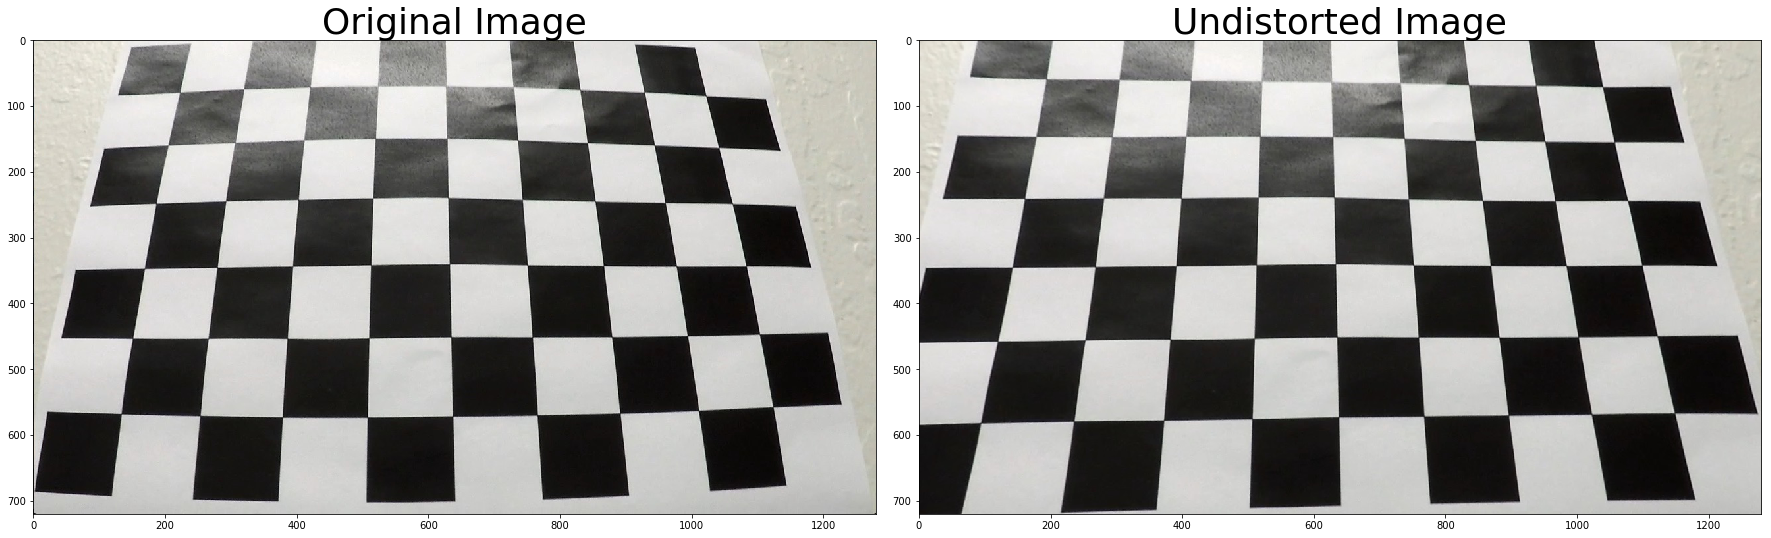

In [2]:
#test the camera calibration works or not
img = mpimg.imread('camera_cal/calibration3.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=36)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=36)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

mpimg.imsave("output_images/original_image",img)
mpimg.imsave('output_images/undistorted_image',undistorted)

#### Threshoding Binary Image for Color and Gradients

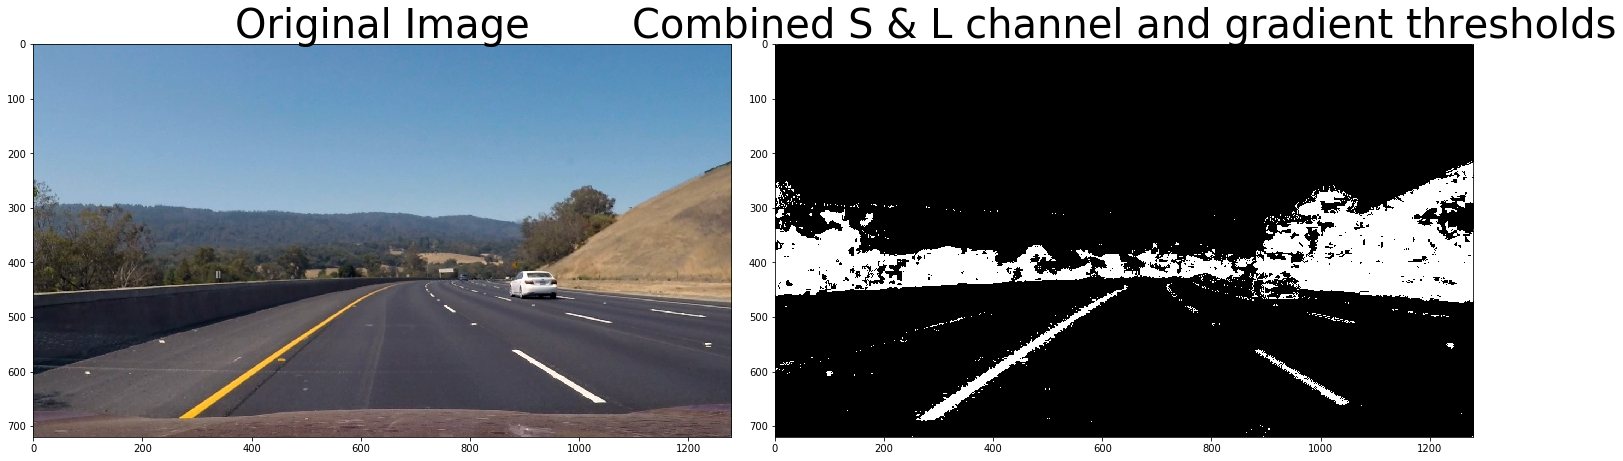

In [3]:
# Use color transforms, gradients, etc., to create a thresholded binary image.

image = mpimg.imread('test_images/test3.jpg')

# create color and gradient pipeline.
def pipeline(img, s_thresh=(130, 255), h_thresh=(15,100),sx_thresh=(20, 100)):
    # get a copy of original image to manipulate
    #img = np.copy(img)
    
    ## Gradient Space
    # gray scale the image for gradient processing
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x, which pick up vertical lane lines
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) #gray scaled is (0,1), now convert back to (0,255)
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    ## Color Space
    # Convert to HLS color space and separate the l and s channel
    # openCV automatically covert the image pixel from 256 to 8bit
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #l_channel = hls[:,:,1]
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]
    # Threshold color channel: s
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # h channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    ## Stack space and color channels together
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary, h_binary)) * 255 
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) |(h_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    
img_threaded = pipeline(image, s_thresh=(130, 255), h_thresh=(15,80), sx_thresh=(40, 100))
cv2.imwrite('output_images/threadholded_binary.png',img_threaded)
#result = cv2.undistort(img, mtx,dist, None, mtx)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()

ax1.set_title('Original Image', fontsize=40)
ax1.imshow(image)


ax2.set_title('Combined S & L channel and gradient thresholds', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
ax2.imshow(img_threaded,cmap='gray')

#### Perspective Transform of Lane

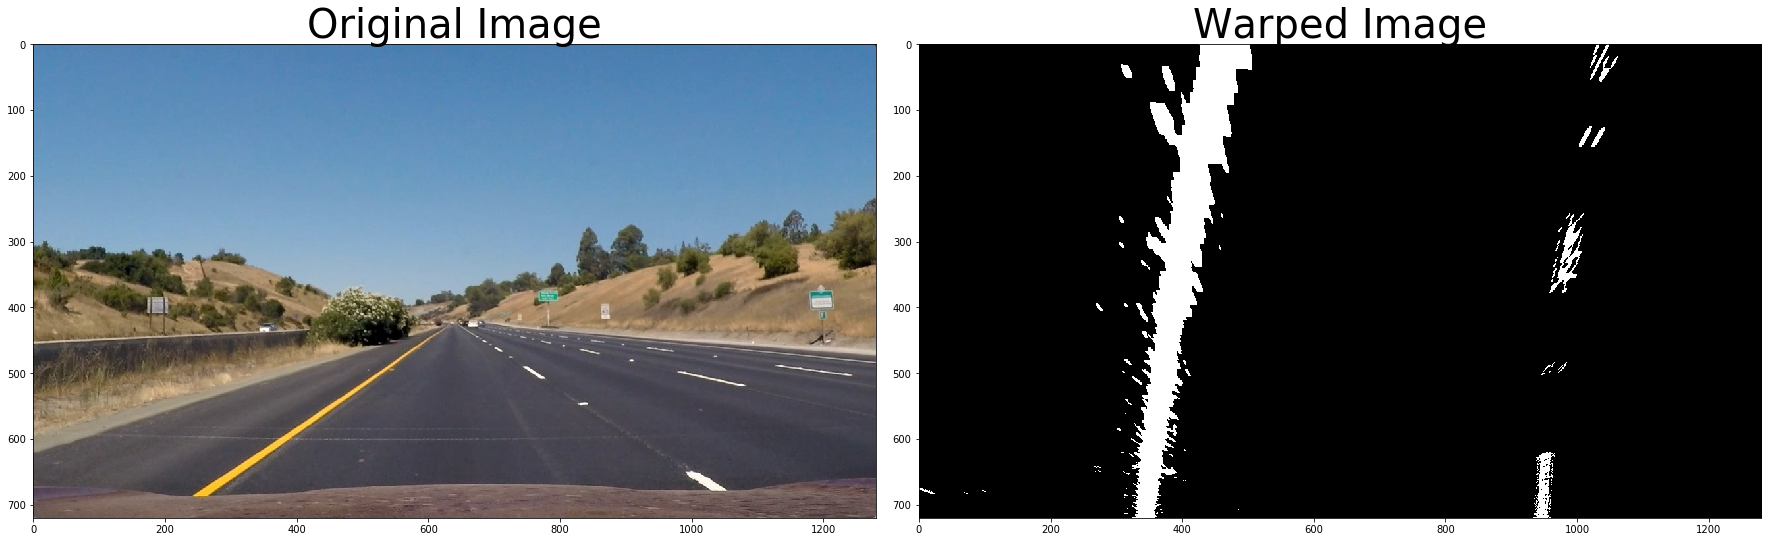

In [4]:
# Apply a perspective transform to rectify binary image ("birds-eye view")

# Load our image
img = mpimg.imread('test_images/straight_lines1.jpg')
img_size = (img.shape[1],img.shape[0])

#top right, bottom right, bottom left, top left
src = np.float32([[705, 461],[999, 650],[303,650],[581, 462]])
dst = np.float32([[920,1],[920, 720],[320,720],[320,1]])
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst,src)
warped = cv2.warpPerspective(img_threaded,M,img_size,flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(warped,cmap='gray')
ax2.set_title('Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Sliding Window: Detect Lane Pixels, Fit to Polynominal, and to Find Lane Boundary

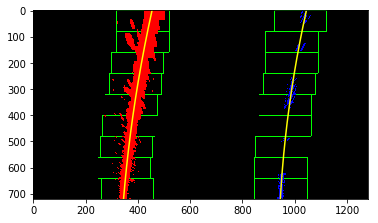

In [5]:
# Detect lane pixels and fit to find the lane boundary.

# Load our image
binary_warped = warped

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img,left_fitx,right_fitx,ploty,left_fit,right_fit


out_img,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(binary_warped)

plt.imshow(out_img)

#### Get a New Binary Warped Image Before Processing Skip Sliding Windows Once Found the Lines

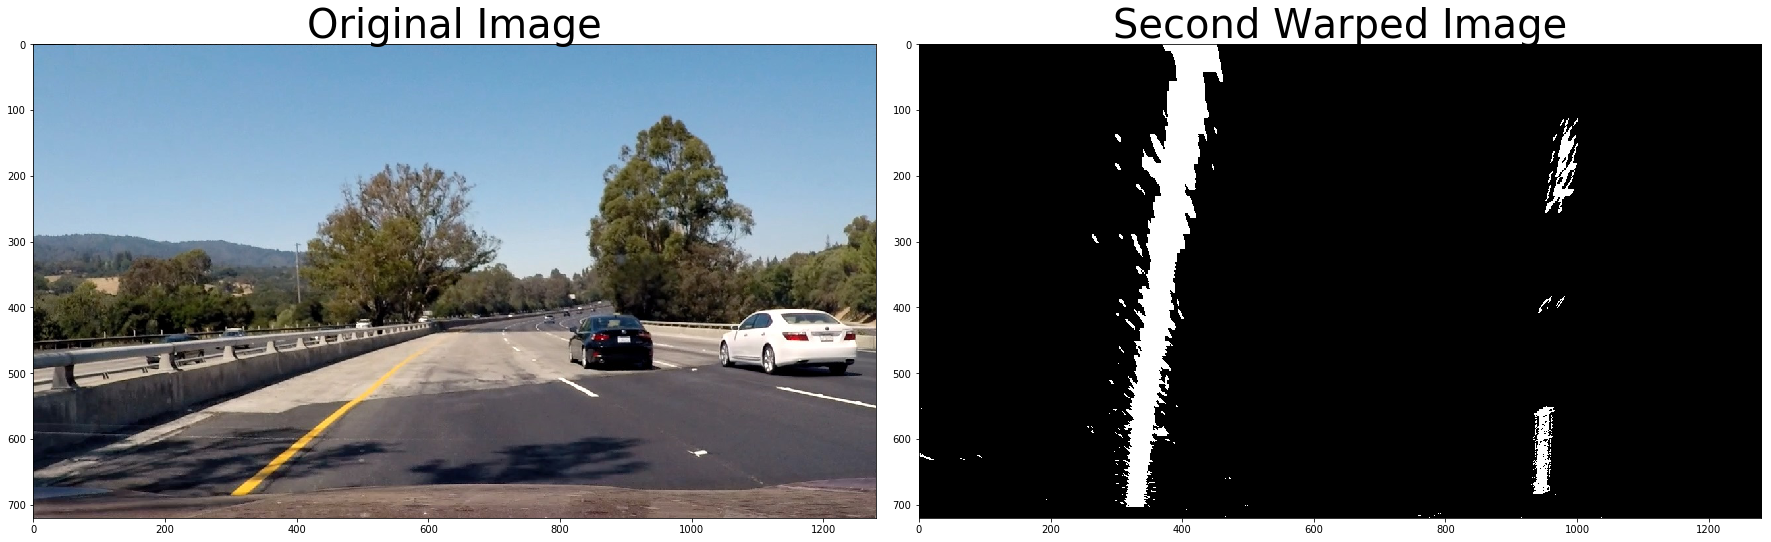

In [6]:
# Get a new binary warped image
# Apply a perspective transform to rectify binary image ("birds-eye view")

# Load our image
img = mpimg.imread('test_images/test4.jpg')
img_size = (img.shape[1],img.shape[0])

src = np.float32([[722, 470],[1110, 720],[220,720],[570, 470]])

dst = np.float32([[920,1],[920, 720],[320,720],[320,1]])
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst,src)
warped_2 = cv2.warpPerspective(img_threaded,M,img_size,flags=cv2.INTER_LINEAR)
cv2.imwrite('output_images/img_warped.jpg',warped_2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(warped_2,cmap='gray')
ax2.set_title('Second Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Skip Sliding Windows Once Found the Lines

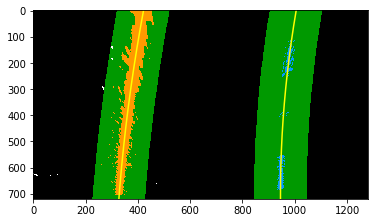

In [7]:
# Load our image - this should be a new frame since last time!
binary_warped = warped_2

# Polynomial fit values from the previous frame: left_fit, right_fit

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    # np.polyfit order is y first, then x
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values
    # within the +/- margin of our polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.6, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return result,left_fitx,right_fitx,ploty,left_fit,right_fit

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result,left_fitx,right_fitx,ploty,left_fit,right_fit = search_around_poly(binary_warped)

# View your output
plt.imshow(result)

#### Measure Radius of Curvatures

In [8]:
# Determine the curvature of the lane and vehicle position with respect to center
# we have polynomial fits and we can calculate the radius of curvature
# converting our x and y values to real world space in meters

def measure_curvature_real(left_fitx, right_fitx,ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    # the physical lane is about 30 meters long and 3.7 meters wide
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Fit a second order polynomial to pixel positions in each lane line
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(left_fitx, right_fitx,ploty)

print('left curvature: %.2f'% left_curverad, 'm', ';    right curvature: %.2f' % right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number


left curvature: 2141.41 m ;    right curvature: 1351.64 m


 #### Find Center of Lane

In [9]:
 # Distance from center is image height/2 - mean of left_fit and right_fit intercepts 
binary_warped = warped_2
h = binary_warped.shape[0]

def find_lane_center(binary_img, l_fit, r_fit):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
#     if left_fitx is not None and right_fitx is not None:
    if r_fit is not None and l_fit is not None:
        car_position = binary_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return center_dist


center_dist = find_lane_center(binary_warped, left_fit, right_fit)
print("the distance to the lane center is: %.2f" %center_dist, "m")

the distance to the lane center is: -0.03 m


#### Draw the Detected Lane Boundaries onto the Original Image

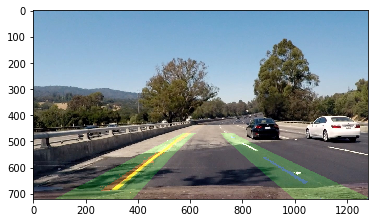

In [10]:
# Warp the detected lane boundaries back onto the original image
# to draw the detected lanes back on to the undistorted image

stacked_img = np.dstack((warped_2, warped_2, warped_2))*255
num_rows = warped_2.shape[0]
img_size = (stacked_img.shape[1],stacked_img.shape[0])

y_points = np.linspace(0, num_rows-1, num_rows)

left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))

right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))

line_points = np.vstack((left_line_window, right_line_window))

cv2.fillPoly(stacked_img, np.int_([line_points]), [0,255, 0])

unwarped = cv2.warpPerspective(result, Minv, img_size , flags=cv2.INTER_LINEAR)

result = cv2.addWeighted(img, 1, unwarped, 0.3, 0) #img is the original image to draw on

plt.imshow(result)

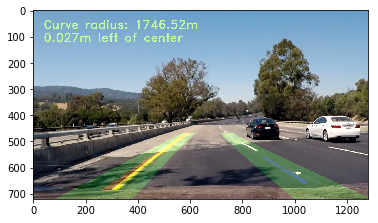

In [11]:
# Output visual display of the lane boundaries and numerical estimation 
# of lane curvature and vehicle position
# image = mpimg.imread('test_images/test3.jpg')
image = result

def draw_data_on_lane(result_img, curv_rad, center_dist):
    new_img = np.copy(result_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

data_on_original_image = draw_data_on_lane(image, (left_curverad+ right_curverad)/2, center_dist)
plt.imshow(data_on_original_image)

### Part 2: Pipeline for Finding the Lines: Search from Prior 

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

In [2]:
# func of camera calibration
def camera_calibration():
    # Arrays to store object points and image points from all the images
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # prepare object points
    nx = 9
    ny = 6

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Make a list of calibration images
    fnames = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in fnames:
        img = cv2.imread(fname)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        # If found, draw corners
        if ret == True:
        # Draw and display the corners
            objpoints.append(objp)
            imgpoints.append(corners)
        # Use cv2.calibrateCamera() and cv2.undistort()
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)
    return ret, mtx, dist, rvecs, tvecs

In [3]:
# func to create a color-and-gradient thresholded binary image
def get_threshold(img, s_thresh=(130, 255), h_thresh=(15,100),sx_thresh=(20, 100)):
    ## Gradient Space
    # gray scale the image for gradient processing
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x, which pick up vertical lane lines
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) #gray scaled is (0,1), now convert back to (0,255)
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    ## Color Space
    # Convert to HLS color space and separate the l and s channel
    # openCV automatically covert the image pixel from 256 to 8bit
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #l_channel = hls[:,:,1]
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]
    # Threshold color channel: s
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # h channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) |(h_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

In [4]:
# func to crate warped image (birds-eye-view)

def warped_image(img, img_threaded):
    img_size = (img.shape[1],img.shape[0])
    # define 4 source points src = np.float32([[,],[,],[,],[,]])
    # pick any four of the detected corners as long as those four corners define a rectangle
    # use four well-chosen corners that were automatically detected during the undistortion steps
    # define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    # use cv2.warpPerspective() to warp your image to a top-down view

    src = np.float32([[722, 470],[1110, 720],[220,720],[570, 470]])
    dst = np.float32([[920,1],[920, 720],[320,720],[320,1]])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img_threaded,M,img_size,flags=cv2.INTER_LINEAR)
    return warped,Minv

In [5]:
def brute_search_lane_lines(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

# func to fit polynominal to a warped image to find the lane boundary
def fit_polynomial_brute_search(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = brute_search_lane_lines(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return out_img,left_fitx,right_fitx,left_fit,right_fit,ploty #out_img: lane line fitted binary image

In [6]:
# func of polynomial fit to the new image using the values from the previous frame: left_fit, right_fit
# input warped_2 which is warped binary image
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    # np.polyfit order is y first, then x
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

# func of searching a small margin instead of the whole width of the image for the next frame
def search_around_poly(warped_2,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = warped_2.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values
    # within the +/- margin of our polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(warped_2.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped_2, warped_2, warped_2))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.6, 0)
    
    return result,left_fitx,right_fitx,left_fit,right_fit,ploty

In [7]:
# func of calculating left and right curvature in meters

def measure_curvature_real(left_fitx, right_fitx,ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    # the physical lane is about 30 meters long and 3.7 meters wide
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
      
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [8]:
# func to find lane center to the car
def find_lane_center(binary_img, l_fit, r_fit):
    h = binary_img.shape[0]
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    if r_fit is not None and l_fit is not None:
        car_position = binary_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return center_dist

In [9]:
# func to draw the detected lanes on undistored/original image
# image: the original image to draw on
# return result, which is the overlapped lane detected image

def draw_detected_lane(warped,out_img,img,left_fitx, right_fitx, Minv):
    stacked_img = np.dstack((warped, warped, warped))*255
    num_rows = warped.shape[0]
    img_size = (stacked_img.shape[1],stacked_img.shape[0])

    y_points = np.linspace(0, num_rows-1, num_rows)
    left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))
    line_points = np.vstack((left_line_window, right_line_window))

    # Fills the area bounded by one or more polygons
#     cv2.fillPoly(stacked_img, np.int_([line_points]), [0,255, 0])
    cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
    unwarped = cv2.warpPerspective(out_img, Minv, img_size , flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0) #img is the original image to draw on
    return result

In [10]:
# func to put curvature and center to the lane data on the above lane detected image
def draw_data_on_lane(result_img,left_curverad, right_curverad, center_dist):
    new_img = np.copy(result_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    curv_radius = (left_curverad+ right_curverad)/2
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_radius) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

Define the pipeline function

In [11]:
# calibration camera, this is only needed for once to get the camera matrix M
# call this function before calling advanced_lane_finding function
vet,mtx,dist,rvecs,tvecs = camera_calibration()

def advanced_lane_finding(img):
    global left_fit
    global right_fit
    # get color and gradient thresholded binary image that picked up lane lines
    combined_binary = get_threshold(img,s_thresh=(130, 255), h_thresh=(15,100),sx_thresh=(20, 100))
    # perform a perspective transform to get the birdview of lane lines
    warped,Minv = warped_image(img, combined_binary)
    # if the polynomial coefficients of the previous frame is None then sliding windows to search fitted lane line
    # else if there are previous lane lines polynominal coefficients, then search a small margin for the current frame
    if (left_fit is None) or (right_fit is None):
        lane_detected_img,left_fitx,right_fitx,left_fit,right_fit,ploty = fit_polynomial_brute_search(warped)
    else:
        # Make sure to grab the actual values from the previous step in your project!
        left_fit = np.array(left_fit)
        right_fit = np.array(right_fit)
        lane_detected_img,left_fitx,right_fitx,left_fit,right_fit,ploty = search_around_poly(warped,left_fit,right_fit) 

    # compute the radius of curvature
    left_curverad,right_curverad = measure_curvature_real(left_fitx,right_fitx,ploty)
    # compute the offset of lane center
    center_dist = find_lane_center(warped,left_fit,right_fit)
    # output lane detected poly drawing on the original image
    result_img = draw_detected_lane(warped,lane_detected_img,img,left_fitx,right_fitx,Minv)
    # output the lane detection, curvature and offset of lane center image
    data_img = draw_data_on_lane(result_img,left_curverad,right_curverad,center_dist)
    data_img = np.array(data_img)
    return data_img

Test on an image input

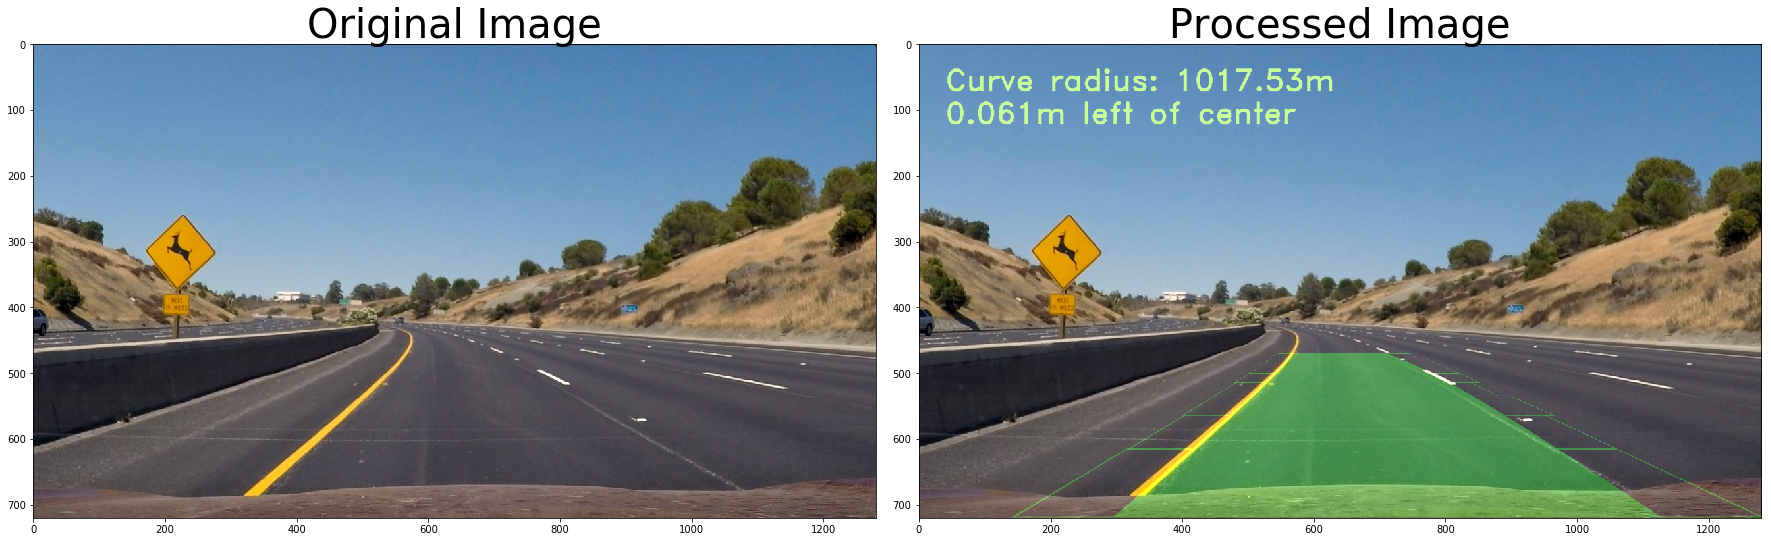

In [12]:
# global variables to store good found left and right lane lines
left_fit = None
right_fit = None

# test on first image
img = mpimg.imread('test_images/test2.jpg')
data_img =advanced_lane_finding(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(data_img)
ax2.set_title('Processed Image', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

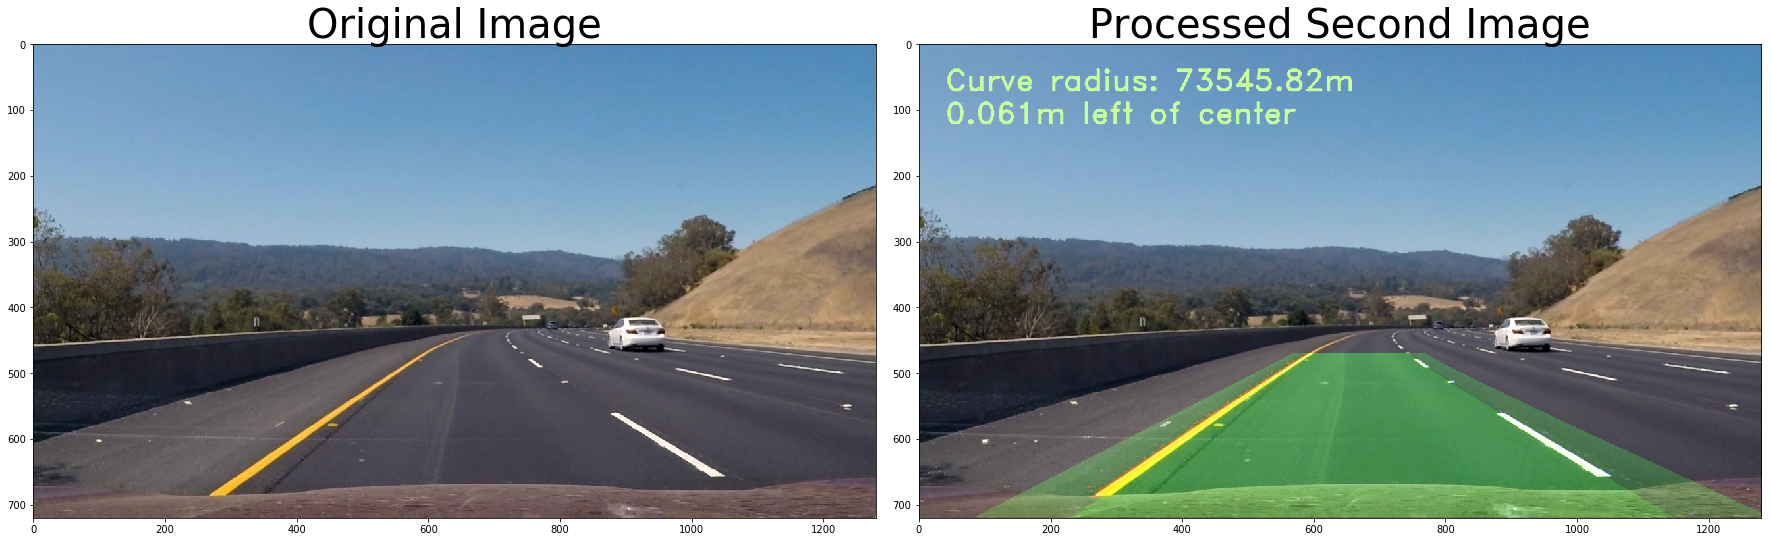

In [13]:
# test on second image
img = mpimg.imread('test_images/test3.jpg')
data_img =advanced_lane_finding(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(data_img)
ax2.set_title('Processed Second Image', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Run the Search from Prior Pipeline on Videos

pipeline "advanced_lane_finding(img)" works for "project_video.mp4"

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# global variables to store good found left and right lane lines
left_fit = None
right_fit = None

video_output_name_2 = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# input_clip1 = VideoFileClip('project_video.mp4').subclip(0,5)
input_clip2 = VideoFileClip('project_video.mp4')
output_clip2 = input_clip2.fl_image(advanced_lane_finding)
%time output_clip2.write_videofile(video_output_name_2, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:58<00:00,  4.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 20s, sys: 25.8 s, total: 2min 45s
Wall time: 5min 1s


pipeline "advanced_lane_finding(img)" works 95%+ for "challenge_video.mp4"

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# global variables to store good found left and right lane lines
left_fit = None
right_fit = None

video_output_name_3 = 'challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#input_clip3 = VideoFileClip('challenge_video.mp4').subclip(0,5)
input_clip3 = VideoFileClip('challenge_video.mp4')
output_clip3 = input_clip3.fl_image(advanced_lane_finding)
%time output_clip3.write_videofile(video_output_name_3, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [02:18<00:00,  3.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 2s, sys: 8.43 s, total: 1min 11s
Wall time: 2min 21s


In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# global variables to store good found left and right lane lines
left_fit = None
right_fit = None

video_output_name_4 = 'harder_challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#input_clip3 = VideoFileClip('challenge_video.mp4').subclip(0,5)
input_clip4 = VideoFileClip('harder_challenge_video.mp4')
output_clip4 = input_clip4.fl_image(advanced_lane_finding)
%time output_clip4.write_videofile(video_output_name_4, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [05:42<00:00,  3.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 2min 39s, sys: 23.5 s, total: 3min 2s
Wall time: 5min 46s


#### Experiment: Another Sliding Windows- Apply Convolution

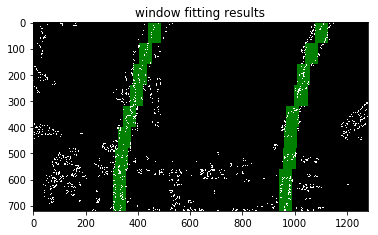

In [2]:
# test the pipeline on a warped image 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
warped = mpimg.imread('examples/warped_example.jpg')
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,image.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,image.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()
